# Mask Detection using MobilenetV2

Here is a step by step guide to make a classifier that can classify the faces as wearing mask, not wearing a mask and not wearing a mask properly.

The biggest challenge is here to convert the available data to the form we can use it. It is going to take most of our time.So let us explore the data. Our dataset contains two folders, one having images and other having annotations.Since each of these images contain multiple persons which are either wearing a mask or not weraing it or not wearing it properly, we need to get these faces out of the images.

The annotations file of each file will help in that as it contains information about where the face it and under which category does  it fall

So here a brief summary of what we are going to do here
1. First we are going to go through all the annotations file and parse the information using beautifulsoap.Later we are going to make a list which contains a dictionary having information about coordinates of faces and the labels of each face. 
2. Next we will use opencv to read the image , extract the face areas from it, preprocess it and save it to a list.We are going to save the labels simuntaneosly in another list
3. Now we will finetune the MobilenetV2 model and get the results.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [2]:
#import the libraries
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random as rand

/Users/samantha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/samantha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/samantha/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/samantha/opt/anaconda3/lib/python3.7/site-packages/ten

In [3]:
# Defiine functions that performs task 1 mentioned above

#This function will get the coordinates of face given in the annotations file
# the coordinates of lower left corner and upper right corner
def generate_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]
#This function will give label assciated with each label and convert them to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0
#Using in this main function we parse the annotations file and get the objects out from them
# Also we use the above two functions here 
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_id)
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [4]:
imgs = list(sorted(os.listdir("/Users/samantha/Downloads/Kaggle Mask/images/")))
len(imgs)

853

In [5]:
labels = list(sorted(os.listdir("/Users/samantha/Downloads/Kaggle Mask/annotations/")))

In [6]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("/Users/samantha/Downloads/Kaggle Mask/images/", file_image)
    label_path = os.path.join("/Users/samantha/Downloads/Kaggle Mask/annotations/", file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)
    

In [7]:
#In this step we carry forward the second step mentioned above.
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
face_images=[]
face_labels=[]
for i in range(853):
    img_path = r"/Users/samantha/Downloads/Kaggle Mask/images/maksssksksss{}.png".format(i)
    #read image
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
#       get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#     Get the face from the image using the coordinates
#the arguments are as ymin , ymax and xmin xmax
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)



Next we check total number of faces detected and how many belong to each class. We see that the images in which mask is woren properly are really less. We will increase their weight when training the model.

In [8]:
len(face_labels)

4072

In [9]:
unique, counts = np.unique(face_labels, return_counts=True)
dict(zip(unique, counts))

{0: 717, 1: 3232, 2: 123}

In [10]:
#Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [11]:
#Perform data augmentation.
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [12]:
aug2 = ImageDataGenerator( fill_mode="nearest")

In [16]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/Users/samantha/opt/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [17]:
#define the hyperparamets for traing te neural network
INIT_LR = 1e-4
EPOCHS = 5
BS = 1

In [18]:
#divide data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [20]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
start = time.time()
H = model.fit(
  aug.flow(trainX, trainY, batch_size=BS),
  steps_per_epoch=len(trainX) // BS,
  validation_data=(testX, testY),
  validation_steps=len(testX) // BS,
  epochs=EPOCHS)
print("Total time: ", time.time() - start, "seconds")

[INFO] training head...
Epoch 1/5
3257/3257 [==============================] - 161s 49ms/step - loss: 0.6459 - acc: 0.7937 - val_loss: 0.6622 - val_acc: 0.7914
Epoch 2/5
3257/3257 [==============================] - 162s 50ms/step - loss: 0.6365 - acc: 0.7937 - val_loss: 0.6607 - val_acc: 0.7939
Epoch 3/5
3257/3257 [==============================] - 158s 49ms/step - loss: 0.6359 - acc: 0.7937 - val_loss: 0.6548 - val_acc: 0.7951
Epoch 4/5
3257/3257 [==============================] - 161s 50ms/step - loss: 0.6273 - acc: 0.7937 - val_loss: 0.6712 - val_acc: 0.7939
Epoch 5/5
3257/3257 [==============================] - 153s 47ms/step - loss: 0.6295 - acc: 0.7937 - val_loss: 0.6541 - val_acc: 0.7926
Total time:  796.1982910633087 seconds


In [19]:
#Complie the model and train it
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
start = time.time()
R = model.fit(
  aug2.flow(trainX, trainY, batch_size=BS),
  steps_per_epoch=len(trainX) // BS,
  validation_data=(testX, testY),
  validation_steps=len(testX) // BS,
  epochs=EPOCHS)
print("Total time: ", time.time() - start, "seconds")

[INFO] training head...
Epoch 1/5
3257/3257 [==============================] - 162s 50ms/step - loss: 0.6465 - acc: 0.7881 - val_loss: 0.6802 - val_acc: 0.7890
Epoch 2/5
3257/3257 [==============================] - 144s 44ms/step - loss: 0.6541 - acc: 0.7937 - val_loss: 0.6599 - val_acc: 0.7914
Epoch 3/5
3257/3257 [==============================] - 142s 44ms/step - loss: 0.6459 - acc: 0.7937 - val_loss: 0.6566 - val_acc: 0.7939
Epoch 4/5
3257/3257 [==============================] - 143s 44ms/step - loss: 0.6380 - acc: 0.7937 - val_loss: 0.6793 - val_acc: 0.7939
Epoch 5/5
3257/3257 [==============================] - 143s 44ms/step - loss: 0.6316 - acc: 0.7937 - val_loss: 0.6601 - val_acc: 0.7939
Total time:  734.2653858661652 seconds


The next step is to evaluate the model and plot the graphs showing the learning process.

[INFO] evaluating augmented data network...
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       143
           1       0.79      1.00      0.88       647
           2       0.00      0.00      0.00        25

    accuracy                           0.79       815
   macro avg       0.38      0.33      0.30       815
weighted avg       0.69      0.79      0.70       815



/Users/samantha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


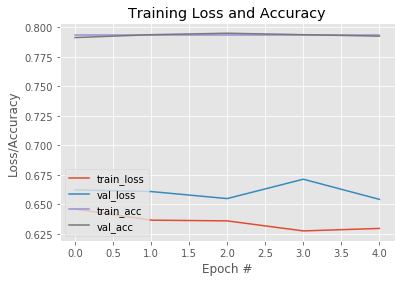

In [21]:
print("[INFO] evaluating augmented data network...")
predIdxs = model.predict(testX, batch_size=1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

[INFO] evaluating the difference in accuracy based on augmentation
              precision    recall  f1-score   support

           0       0.33      0.01      0.01       143
           1       0.79      1.00      0.88       647
           2       0.00      0.00      0.00        25

    accuracy                           0.79       815
   macro avg       0.38      0.33      0.30       815
weighted avg       0.69      0.79      0.70       815



/Users/samantha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


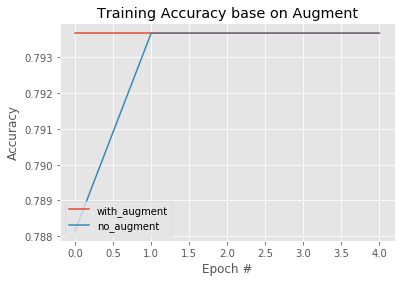

In [23]:
print("[INFO] evaluating the difference in accuracy based on augmentation")
predIdxs = model.predict(testX, batch_size=1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs
	))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["acc"], label="with_augment")
plt.plot(np.arange(0, N), R.history["acc"], label="no_augment")
plt.title("Training Accuracy base on Augment")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()